In [1]:
!pwd
!export PYTHONPATH=$PYTHONPATH:$(pwd)/evidential-learning-pytorch

import sys
print(sys.path)
sys.path.append('/work/DRO-EDL/1d/evidential-learning-pytorch')

from tqdm import tqdm
from scipy.stats import norm

import numpy as np
from scipy.stats import norm, invgamma

import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.integrate import dblquad

import torch

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from edl_pytorch import NormalInvGamma, evidential_regression

import torch.optim as optim

/work/DRO-EDL/1d
['/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/opencda/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages']


In [12]:
def cart2polar(x,y):
    r = (x**2 + y**2)**(1/2)
    theta = np.arccos(x/r)
    return r , theta

def polar2cart(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y

In [47]:
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 1),
)
model.load_state_dict(torch.load(f'uncertain_weights/{15}.pth', weights_only=True))


<All keys matched successfully>

In [48]:
def NIG_sample(params):
    mu_0, lambda_, alpha, beta = params
    x_sigma2_dist = invgamma(alpha, scale=beta)
    sigma2 = x_sigma2_dist.rvs(1)
    x_mu_dist = norm(mu_0, np.sqrt(sigma2 / lambda_))
    mu = x_mu_dist.rvs(1)
    return np.array([mu[0], sigma2[0]])

In [71]:
import pickle
a_memory = dict()
with open(f'a_memory_set/a_memory_{0.9}.pickle', 'rb') as f:
    a_memory = pickle.load(f)

In [106]:

from ipywidgets import interact, FloatSlider

def plot(x,y):
    plt.figure(figsize=(8,8))
    input_data = torch.tensor(cart2polar(*[x,y+1e-6]), dtype=torch.float)
    with torch.no_grad():
        pred = model(input_data)
    params = [pred[0][0], pred[1][0], pred[2][0], pred[3][0]]
    print(params)
    
    # ambiguity set
    mu_0, lambda_, alpha, beta = params
    zx, zy = a_memory[float(f'{alpha:.02f}')]
    delta = zx / np.sqrt(lambda_/beta)
    mu_low, mu_high = mu_0 - delta, mu_0 + delta
    plt.scatter(params[0], 0, color='r', s=100)
    plt.plot([mu_low, mu_high], [0.1,0.1], 'r', marker='o')
    
    # sampling
    for _ in range(100):
        dist_params = NIG_sample(params)

        mu, sigma2 = dist_params
        dist = norm(mu, np.sqrt(sigma2))
        l = np.linspace(mu-20, mu+20)
        if mu_low < mu and mu < mu_high: # inside ambiguity set
            color = 'lime'
            alpha = 0.1
            label = 'in ambiguity set'
        else:
            color = 'skyblue'
            alpha = 0.8
            label = 'out of ambiguity set'
        plt.plot(l, dist.pdf(l), color=color, alpha=alpha)

    plt.xlim(-100, 100)
    plt.ylim(-0.03, 0.8)
    plt.show()


interact(
        plot,
        x=FloatSlider(min=-100, max=100, step=1, value=0, description='Major Axis (a)'),
        y=FloatSlider(min=-100, max=100, step=1, value=0, description='Major Axis (a)'),
);


interactive(children=(FloatSlider(value=0.0, description='Major Axis (a)', min=-100.0, step=1.0), FloatSlider(…

In [107]:
from tqdm import tqdm
from ipywidgets import interact, FloatSlider

y = 10
for idx, x in enumerate(tqdm(range(100, -100, -1))):
    plt.figure(figsize=(8,8))
    input_data = torch.tensor(cart2polar(*[x,y+1e-6]), dtype=torch.float)
    with torch.no_grad():
        pred = model(input_data)
    params = [pred[0][0], pred[1][0], pred[2][0], pred[3][0]]

    # ambiguity set
    mu_0, lambda_, alpha, beta = params
    zx, zy = a_memory[float(f'{alpha:.02f}')]
    delta = zx / np.sqrt(lambda_/beta)
    mu_low, mu_high = mu_0 - delta, mu_0 + delta
    plt.scatter(params[0], 0, color='r', s=100, alpha = 0.7, label='Predicted Mean')
    plt.scatter(x, 0, color='g', s=100, alpha = 0.7, label='Ground Truth')
    plt.plot([mu_low, mu_high], [0.1,0.1], 'r', label='Prediction Range')

    # sampling
    for sample_idx in range(100):
        dist_params = NIG_sample(params)

        mu, sigma2 = dist_params
        dist = norm(mu, np.sqrt(sigma2))
        l = np.linspace(mu-20, mu+20)
        if mu_low < mu and mu < mu_high: # inside ambiguity set
            color = 'lime'
            alpha = 0.1
            label = 'in ambiguity set'
        else:
            color = 'skyblue'
            alpha = 0.8
            label = 'out of ambiguity set'
        
        plt.plot(l, dist.pdf(l), color=color, alpha=alpha, label=label)

    plt.xlim(-100, 100)
    plt.ylim(-0.03, 0.8)
    # 중복 제거: handles와 labels 추출 후 고유한 조합으로 필터링
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # 중복 제거

    # 고유한 레이블만 포함하는 legend 표시
    plt.legend(unique_labels.values(), unique_labels.keys())    
    plt.title("Ambiguity set sample visualization")
    plt.savefig(f'record/{idx}.png')
    plt.close()



100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.60it/s]


In [109]:
from matplotlib.patches import Polygon


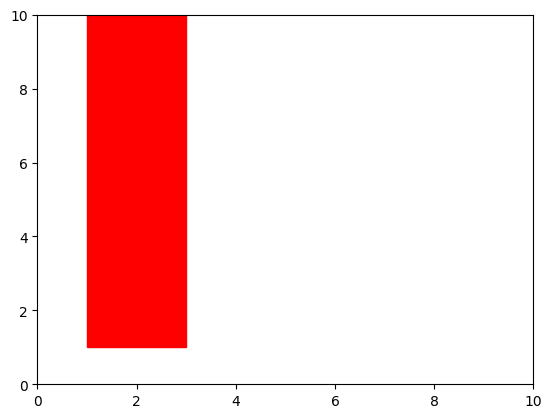

In [116]:
fig, ax = plt.subplots()
vertices = [(1,1), (1,10), (3, 10), (3,1)]

ax.add_patch(Polygon(vertices, closed=True, color='red'))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
plt.show()